<a href="https://colab.research.google.com/github/HanByeonghyun/HanByeonghyun/blob/main/%EC%A4%91%EA%B0%84%EA%B3%A0%EC%82%AC1%EB%B2%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 날씨 데이터 처리 프로그램

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import keras

In [ ]:
#데이터 불러오기
df  = pd.read_csv('/content/drive/MyDrive/자연어처리/jena_climate_2009_2016.csv')

In [ ]:
#데이터 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


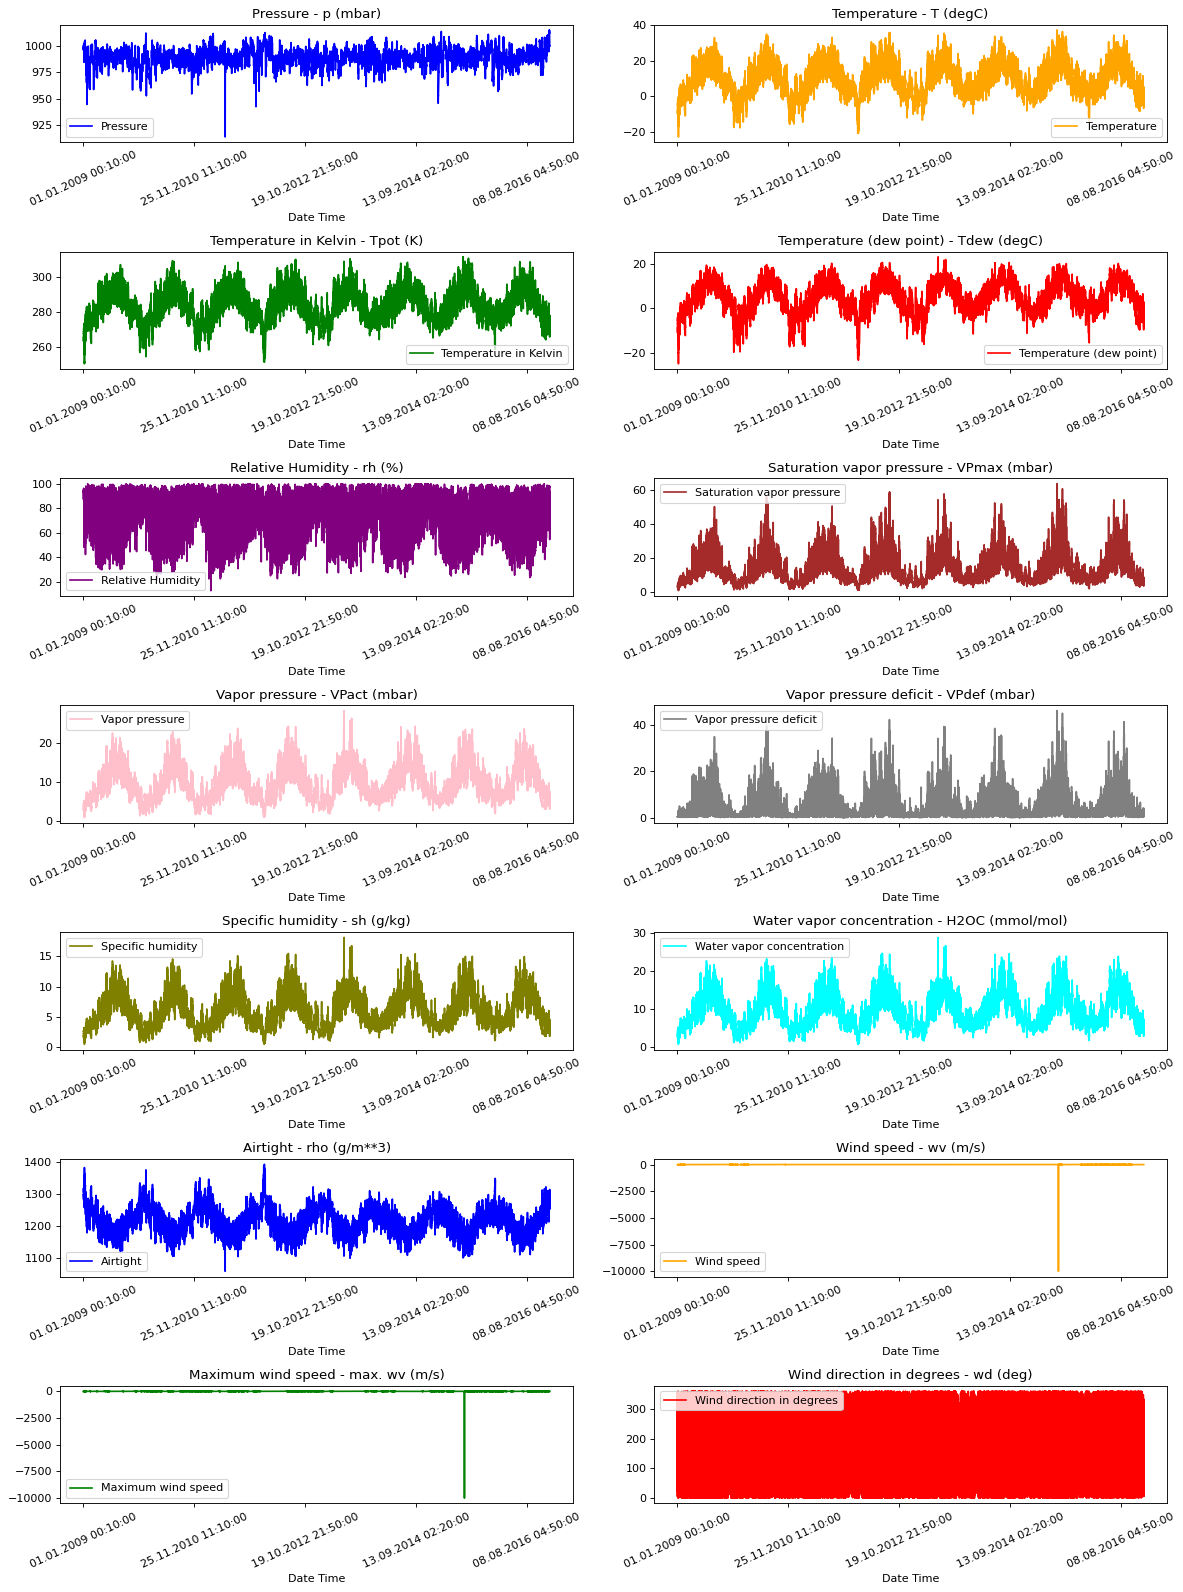

In [ ]:
#각 특성별 히트맵 확인
titles = [ #각 특성별 히트맵의 타이틀 이름
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [ #각 특성의 단위
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [ #각 특성별 히트맵의 색
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time" #히트맵의 x축


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

In [ ]:
#데이터 개수
df.shape[0]

420551

In [ ]:
split_fraction = 0.715 #훈련 데이터 71.5% 모델을 학습하는 데 사용
train_split = int(split_fraction * int(df.shape[0])) #훈련 데이터의 길이
step = 6

#지난 720개의 타임스탬프(120시간)의 데이터를 이용해 72개의 타임스탬프(12시간) 후의 온도를 예측
past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

#훈련 데이터 정규화 함수
#기능 값을 제한하기 위해 정규화수행. 평균을 빼고 각 특성의 표준 편차로 나누어 수
def normalize(data, train_split):
  data_mean = data[:train_split].mean(axis=0)
  data_std = data[:train_split].std(axis=0)
  return (data - data_mean) / data_std

In [ ]:
#몇 가지 매개변수가 중복되어 있기 때문에 중복된 몇 가지 특성은 제외하고 사용
print(
    "사용할 특성:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

사용할 특성: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [ ]:
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
#사용할 특성으로만 데이터 재구성
features = df[selected_features]
features.index = df[date_time_key]
features.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


In [ ]:
#데이터를 0과 1사이로 정규화
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [ ]:
#훈련 데이터, 검증 데이터 생성
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [ ]:
#720 + 72 = 792번째 관측치부터 예측
start = past + future
end = start + train_split

#훈련 데이터를 넘파이 배열로 변환
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [ ]:
#모델 훈련에 사용할 시계열 데이터 셋을 만들기 위해 timeseries_dataset_from_array()함수 사용
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
#검증 셋에서의
#입력 데이터는 마지막 792개의 행을 제외하고
#타겟 데이터는 처음 792개의 행을 제외해 생성
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

#모델 검증에 사용할 시계열 데이터 셋 생성
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

#모델 생성
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5153 (20.13 KB)
Trainable params: 5153 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
path_checkpoint = "/content/drive/MyDrive/자연어처리/model_checkpoint.weights.h5"
#검증 손실(val_loss)이 5번의 epochs동안 줄어들지 않으면 훈련 조기 종료하는 콜백
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

#정기적으로 가장 좋은 모델과 모델의 가중치를 저장
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1776
Epoch 1: val_loss improved from inf to 0.15098, saving model to /content/drive/MyDrive/자연어처리/model_checkpoint.weights.h5
1172/1172 [==============================] - 105s 89ms/step - loss: 0.1776 - val_loss: 0.1510
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1230
Epoch 2: val_loss improved from 0.15098 to 0.14166, saving model to /content/drive/MyDrive/자연어처리/model_checkpoint.weights.h5
1172/1172 [==============================] - 102s 87ms/step - loss: 0.1230 - val_loss: 0.1417
Epoch 3/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1143
Epoch 3: val_loss did not improve from 0.14166
1172/1172 [==============================] - 101s 87ms/step - loss: 0.1143 - val_loss: 0.1437
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1100
Epoch 4: val_loss did not improve from 0.14166
1172/1172 [==============================] - 103s 

8/8 [==============================] - 0s 7ms/step


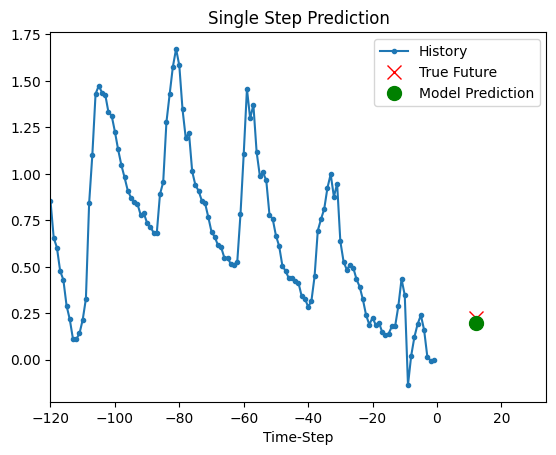

8/8 [==============================] - 0s 8ms/step


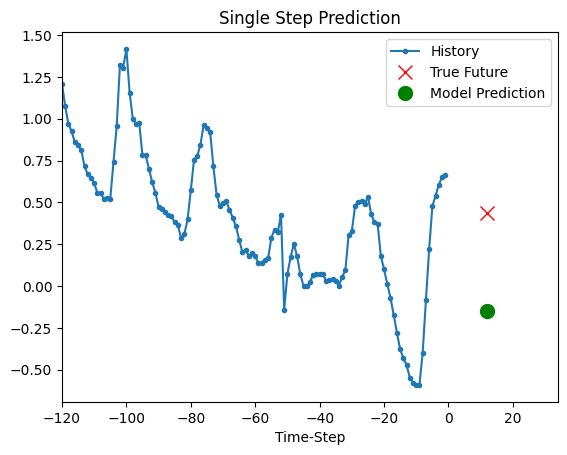

8/8 [==============================] - 0s 7ms/step


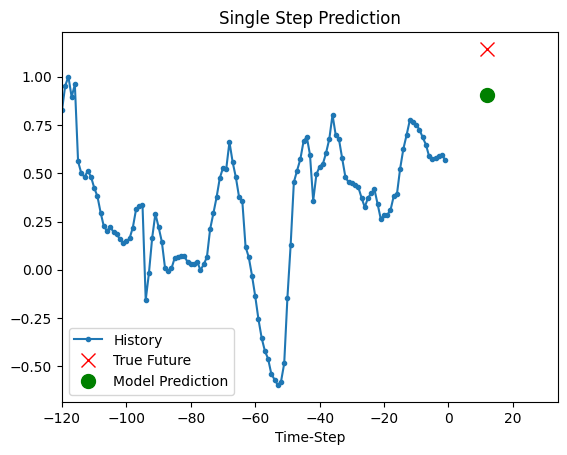

8/8 [==============================] - 0s 9ms/step


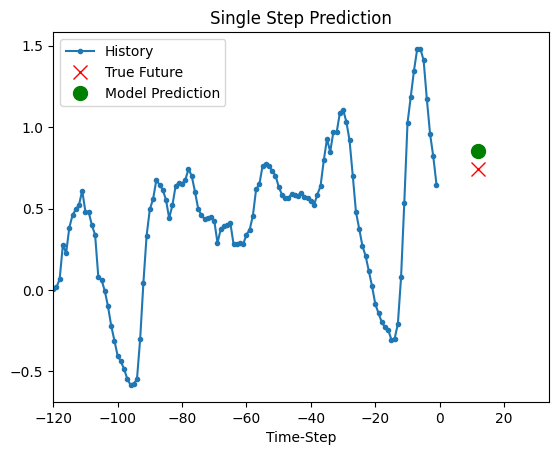

8/8 [==============================] - 0s 7ms/step


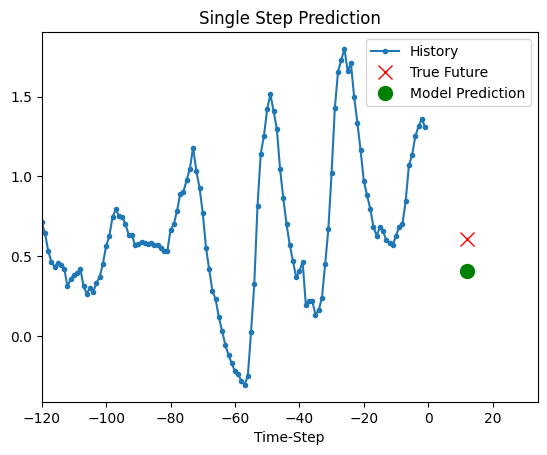

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    #시계열 데이터의 시간을 나타내는 리스트 생성
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    #그래프의 타이틀
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

#검증 셋에서 다섯 개의 샘플을 가져와
#시각화할 데이터를 포함한 리스트, 미래 예측 시간, 그래프의 제목을 넣
#각 샘플의 과거 값, 실제 미래 값, 모델의 예측 값을 시각화
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )